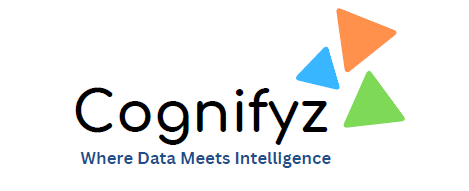

##### NAME - ASHWIN SURESH
##### Domain - Machine Learning
##### Ref. : CTI/A1/C127540

---
---

# Task 2: Restaurant Recommendation

This notebook implements a simple **content‐based filtering** recommender for restaurants, following these steps:

1. Data Load & Quality Checks  
2. Exploratory Data Analysis  
3. Preprocessing & Feature Engineering  
4. Visualize Feature Importance by Variance (Proxy for Influence)
5. Similarity Computation  
6. Evaluate Similarity Methods
7. Recommendation Function using Best Similarity
8. User Interface for personalized reccomendation
9. Interpretation & Business Insights  


---

---



## 1. Data Load & Quality Checks




---



In [6]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
rest_data = pd.read_csv('/content/drive/MyDrive/Dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

In [7]:
display(rest_data.head())

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


---

In [8]:
# Missing values
miss = rest_data.isna().sum()
print("Missing Values: ", miss)

Missing Values:  Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                9
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Aggregate rating        0
Rating color            0
Rating text             0
Votes                   0
dtype: int64


---

In [21]:
# Replacing missing cuisnes with Unknown
rest_data['Cuisines'] = rest_data['Cuisines'].fillna('Unknown')

---

In [22]:
# Duplicates
dup_count = rest_data['Restaurant ID'].duplicated().sum()
print(f"Duplicate Restaurant IDs: {dup_count}")

Duplicate Restaurant IDs: 0


---

In [23]:
# Data types & non-null counts
print("DataFrame info:")
rest_data.info()
print("\n")

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9551 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null   object 
 14  Is delivering now     9551 non-null   object 
 15  Switc

---

In [24]:
# Unique-value counts for object columns
print("Unique values in object columns:")
for col in rest_data.select_dtypes(include=['object']).columns:
    print(f"  {col:25}: {rest_data[col].nunique():4} unique")

Unique values in object columns:
  Restaurant Name          : 7446 unique
  City                     :  141 unique
  Address                  : 8918 unique
  Locality                 : 1208 unique
  Locality Verbose         : 1265 unique
  Cuisines                 : 1826 unique
  Currency                 :   12 unique
  Has Table booking        :    2 unique
  Has Online delivery      :    2 unique
  Is delivering now        :    2 unique
  Switch to order menu     :    1 unique
  Rating color             :    6 unique
  Rating text              :    6 unique


---

In [25]:
# Constant columns (no variance)
constant_cols = [c for c in rest_data.columns if rest_data[c].nunique() <= 1]
print("\nConstant columns (drop if any):", constant_cols)


Constant columns (drop if any): ['Switch to order menu']


---

In [26]:
# Rating sanity check
print("\nRating range:", rest_data['Aggregate rating'].min(), "to", rest_data['Aggregate rating'].max())
print("Counts of negative or zero ratings:", (rest_data['Aggregate rating'] <= 0).sum())


Rating range: 0.0 to 4.9
Counts of negative or zero ratings: 2148


---

In [27]:
# Numeric summary & outlier alerts
num_summary = rest_data[['Price range','Votes','Longitude','Latitude','Aggregate rating']].describe()
display(num_summary)

,Price range,Votes,Longitude,Latitude,Aggregate rating
count,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000
mean,1.804837,156.909748,64.126574,25.854381,2.666370
std,0.905609,430.169145,41.467058,11.007935,1.516378
min,1.000000,0.000000,-157.948486,-41.330428,0.000000
25%,1.000000,5.000000,77.081343,28.478713,2.500000
50%,2.000000,31.000000,77.191964,28.570469,3.200000
75%,2.000000,131.000000,77.282006,28.642758,3.700000
max,4.000000,10934.000000,174.832089,55.976980,4.900000


---

In [28]:
# Negative / impossible values
print("Negative Price range:", (rest_data['Price range'] < 0).sum())
print("Negative Votes      :", (rest_data['Votes'] < 0).sum())

Negative Price range: 0
Negative Votes      : 0


---

---



## 2. Exploratory Data Analysis


---

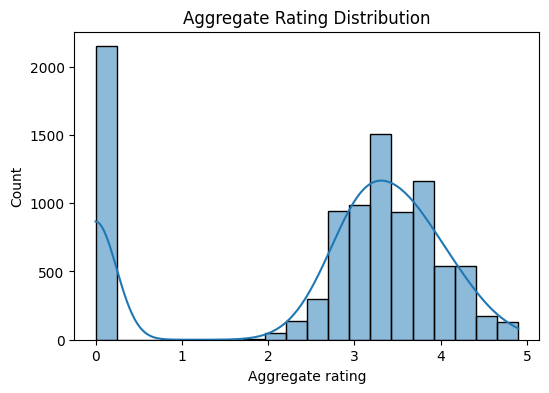

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of ratings
plt.figure(figsize=(6,4))
sns.histplot(rest_data['Aggregate rating'], bins=20, kde=True)
plt.title('Aggregate Rating Distribution')
plt.show()

---

<ipython-input-41-f3a5b1980702>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cuisine_df[cuisine_df['Cuisine'].isin(top_cuisines)],


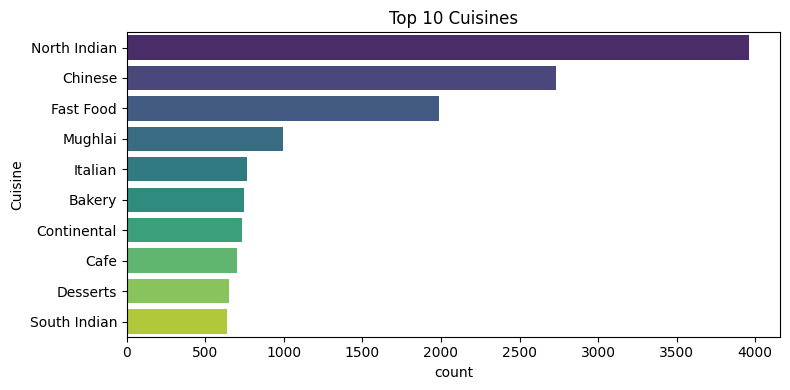

In [41]:
# Top 10 Cuisines
cuisines = rest_data['Cuisines'].dropna().str.split(', ').explode()
cuisine_df = pd.DataFrame({'Cuisine': cuisines})
top_cuisines = cuisine_df['Cuisine'].value_counts().head(10).index

plt.figure(figsize=(8,4))
sns.countplot(data=cuisine_df[cuisine_df['Cuisine'].isin(top_cuisines)],
              y='Cuisine', order=top_cuisines, palette='viridis')
plt.title('Top 10 Cuisines')
plt.tight_layout()
plt.show()

---

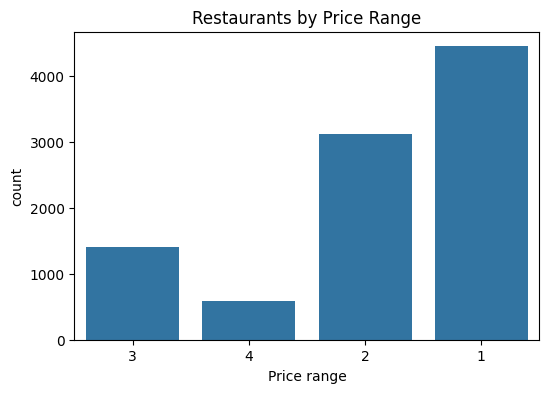

In [31]:
# Price range distribution
plt.figure(figsize=(6,4))
sns.countplot(x=rest_data['Price range'].astype(str))
plt.title('Restaurants by Price Range')
plt.show()

---
---

## 3. Preprocessing & Feature Engineering
- **Numeric features**: Price range, Votes, Aggregate rating  
- **One-hot**: Price range  
- **Text**: Cuisines → TF‑IDF  


In [42]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

---

In [43]:
# Define features
numeric_feats = ['Votes', 'Aggregate rating']
categorical_feats = ['Price range', 'City']
text_feat = 'Cuisines'

---

In [45]:
# Pipelines
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

category_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

---

In [46]:
# Column transformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_feats),
    ('cat', category_pipe, categorical_feats),
    ('txt', TfidfVectorizer(stop_words='english'), text_feat)
])

---

In [48]:
# Fit-transform features
X_feat = preprocessor.fit_transform(rest_data)

---
---

### 4. Visualize Feature Importance by Variance (Proxy for Influence)

---

<ipython-input-71-7fde13fa74e0>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Variance', y='Feature', palette='crest')


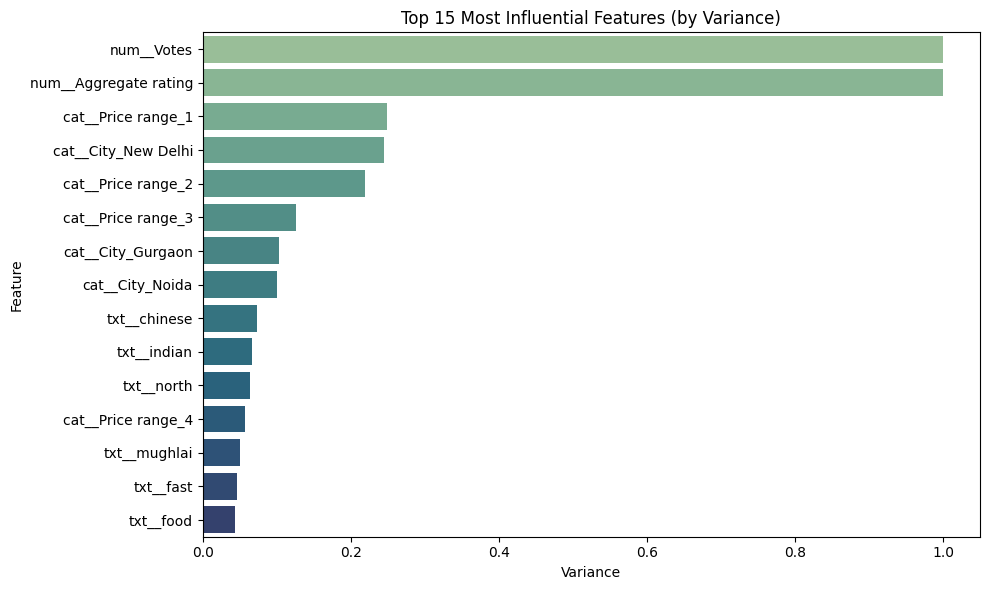

In [71]:
import numpy as np

feature_names = preprocessor.get_feature_names_out()

# Compute feature variances (standard deviation squared)
feature_variances = np.var(X_feat.toarray() if hasattr(X_feat, "toarray") else X_feat, axis=0)

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Variance': feature_variances
}).sort_values(by='Variance', ascending=False).head(15)

# Plot the top 15 features by variance
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Variance', y='Feature', palette='crest')
plt.title('Top 15 Most Influential Features (by Variance)')
plt.tight_layout()
plt.show()

---
---

## 5. Similarity Computation
Compute cosine similarity between restaurant feature vectors.


---

In [49]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import numpy as np

---

In [50]:
# Compute all similarity matrices
cos_sim = cosine_similarity(X_feat)
euc_sim = 1 / (1 + euclidean_distances(X_feat))  # convert distance to similarity
man_sim = 1 / (1 + manhattan_distances(X_feat))

---
---

## 6. Evaluate Similarity Methods


---

In [51]:
def evaluate_similarity(sim_matrix):
    sample_rest_data = rest_data.sample(10, random_state=42)
    successes = 0
    for idx, row in sample_rest_data.iterrows():
        query_rest_data = pd.DataFrame({
            'Cuisines': [row['Cuisines']],
            'City': [row['City']],
            'Price range': [row['Price range']],
            'Votes': [rest_data['Votes'].mean()],
            'Aggregate rating': [rest_data['Aggregate rating'].mean()]
        })
        query_feat = preprocessor.transform(query_rest_data)
        sims = similarity_fn(query_feat, X_feat, sim_matrix)
        top_index = sims.argsort()[::-1][0]
        if row['Cuisines'].split(',')[0] in rest_data.iloc[top_index]['Cuisines']:
            successes += 1
    return successes / len(sample_rest_data)

def similarity_fn(query_feat, matrix, sim_matrix=None):
    if sim_matrix is not None:
        return cosine_similarity(query_feat, matrix)[0]
    return query_feat @ matrix.T  # fallback

---

In [52]:
# Evaluate all three methods
results = {
    'Cosine Similarity': evaluate_similarity(cos_sim),
    'Euclidean Similarity': evaluate_similarity(euc_sim),
    'Manhattan Similarity': evaluate_similarity(man_sim)
}

---

<ipython-input-53-cdd50d448a23>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='magma')


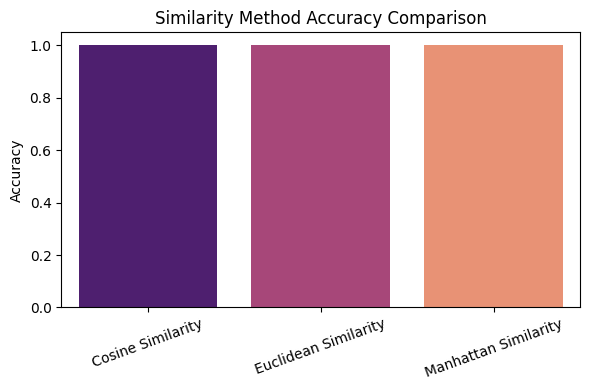

In [53]:
# Display comparison
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='magma')
plt.title('Similarity Method Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

---

In [54]:
# Choose the best similarity matrix
best_method = max(results, key=results.get)
print("Best similarity method:", best_method)

if best_method == 'Cosine Similarity':
    final_sim_matrix = cos_sim
elif best_method == 'Euclidean Similarity':
    final_sim_matrix = euc_sim
else:
    final_sim_matrix = man_sim

Best similarity method: Cosine Similarity


---
---

## 7. Recommendation Function using Best Similarity


---

In [68]:
def get_top_rated_restaurants(cuisine_preference=None, city=None, min_rating=0,
                             price_range=None, online_delivery=None,
                             table_booking=None, rest_data=rest_data, top_n=10):
    rec_rest_data = rest_data.copy()

    if cuisine_preference:
        rec_rest_data = rec_rest_data[rec_rest_data['Cuisines'].str.contains(cuisine_preference, case=False, na=False)]
    if city:
        rec_rest_data = rec_rest_data[rec_rest_data['City'] == city]
    if min_rating > 0:
        rec_rest_data = rec_rest_data[rec_rest_data['Aggregate rating'] >= min_rating]
    if price_range is not None:
        if isinstance(price_range, list):
            rec_rest_data = rec_rest_data[rec_rest_data['Price range'].isin(price_range)]
        else:
            rec_rest_data = rec_rest_data[rec_rest_data['Price range'] == price_range]
    if online_delivery is not None:
        rec_rest_data = rec_rest_data[rec_rest_data['Has Online delivery'] == online_delivery]
    if table_booking is not None:
        rec_rest_data = rec_rest_data[rec_rest_data['Has Table booking'] == table_booking]

    # Use similarity model to boost scores
    query_vector = preprocessor.transform(pd.DataFrame({
        'Cuisines': [cuisine_preference or rest_data['Cuisines'].mode()[0]],
        'City': [city or rest_data['City'].mode()[0]],
        'Price range': [price_range or rest_data['Price range'].mode()[0]],
        'Votes': [rest_data['Votes'].mean()],
        'Aggregate rating': [rest_data['Aggregate rating'].mean()]
    }))

    if best_method == 'Cosine Similarity':
        all_similarities = cosine_similarity(query_vector, X_feat)[0]
    elif best_method == 'Euclidean Similarity':
        all_similarities = 1 / (1 + euclidean_distances(query_vector, X_feat)[0])
    else:
        all_similarities = 1 / (1 + manhattan_distances(query_vector, X_feat)[0])

    # Attach similarities to full DataFrame first
    full_with_sim = rest_data.copy()
    full_with_sim['Similarity'] = all_similarities

    # Apply filtering on full DataFrame with similarity attached
    if cuisine_preference:
        full_with_sim = full_with_sim[full_with_sim['Cuisines'].str.contains(cuisine_preference, case=False, na=False)]
    if city:
        full_with_sim = full_with_sim[full_with_sim['City'] == city]
    if min_rating > 0:
        full_with_sim = full_with_sim[full_with_sim['Aggregate rating'] >= min_rating]
    if price_range is not None:
        if isinstance(price_range, list):
            full_with_sim = full_with_sim[full_with_sim['Price range'].isin(price_range)]
        else:
            full_with_sim = full_with_sim[full_with_sim['Price range'] == price_range]
    if online_delivery is not None:
        full_with_sim = full_with_sim[full_with_sim['Has Online delivery'] == online_delivery]
    if table_booking is not None:
        full_with_sim = full_with_sim[full_with_sim['Has Table booking'] == table_booking]

    # Final sort and return
    full_with_sim = full_with_sim.sort_values(by=['Similarity', 'Aggregate rating', 'Votes'], ascending=[False, False, False])
    return full_with_sim.head(top_n)[['Restaurant Name', 'Cuisines', 'Aggregate rating', 'Votes',
                                      'Price range', 'City', 'Average Cost for two',
                                      'Has Online delivery', 'Has Table booking']]


---
---

## 8. User Interface



In [69]:
def interactive_recommender():
    print("\n🎯 Restaurant Recommender (Rating + Similarity Enhanced) 🎯")
    try:
        cuisine = input("Enter preferred cuisine (e.g., Italian): ")
        city = input("Enter city: ")
        price_input = input("Enter price range (1-4): ")
        price = int(price_input) if price_input.strip() else None
        min_rating = float(input("Minimum rating (0-5): ") or 0)
        online_delivery = input("Require online delivery? (yes/no): ").strip().lower()
        table_booking = input("Require table booking? (yes/no): ").strip().lower()

        online_delivery = True if online_delivery == 'yes' else False if online_delivery == 'no' else None
        table_booking = True if table_booking == 'yes' else False if table_booking == 'no' else None

        top_n = int(input("How many recommendations? "))

        recs = get_top_rated_restaurants(
            cuisine_preference=cuisine or None,
            city=city or None,
            min_rating=min_rating,
            price_range=price,
            online_delivery=online_delivery,
            table_booking=table_booking,
            top_n=top_n
        )

        if recs.empty:
            print("No recommendations found.")
        else:
            display(recs.reset_index(drop=True))
    except Exception as e:
        print("Error:", e)


In [70]:
interactive_recommender()



🎯 Restaurant Recommender (Rating + Similarity Enhanced) 🎯
Enter preferred cuisine (e.g., Italian): Italian
Enter city: Jaipur
Enter price range (1-4): 
Minimum rating (0-5): 
Require online delivery? (yes/no): 
Require table booking? (yes/no): 
How many recommendations? 5


,Restaurant Name,Cuisines,Aggregate rating,Votes,Price range,City,Average Cost for two,Has Online delivery,Has Table booking
0,Sky Beach,"North Indian, Continental, Chinese, Mexican, I...",2.6,46,3,Jaipur,1000,No,No
1,Nibs Cafe,"Cafe, Italian, Continental",4.4,389,2,Jaipur,750,Yes,No
2,Mutual's,"Cafe, Mexican, Italian, North Indian, Fast Food",4.2,198,2,Jaipur,650,Yes,No
3,WTF,"Continental, Italian, North Indian, Lebanese, ...",4.0,212,3,Jaipur,1000,No,No
4,Zolocrust - Hotel Clarks Amer,"Italian, Bakery, Continental",4.9,322,4,Jaipur,2000,Yes,No


---
---

## 9. Interpretation & Business Insights

- **Approach:** Content‑based filtering combining cuisine TF‑Irest_data, price, and ratings  
- **Key factors:**  
  - Similar cuisines → higher similarity score  
  - Price range buckets help match affordability  
  - Aggregate ratings bias toward higher‑rated venues  
- **Potential improvements:**  
  1. Introduce **user profiles** to weight criteria (e.g. rating vs. price).  
  2. Blend in **collaborative filtering** for new cuisines.  
  3. Expand **evaluation** with real user feedback and metrics like Recall@K.  


---
---
---